# Deep Brush: Visualizing Artistic Textures with CNNs 🎨🖌️


### Introduction
Overview of the project:

Objective: Detect and visualize artistic textures using CNNs

Technologies used (PyTorch, Grad-CAM, TensorFlow, OpenCV)

## Required Libraries

In [31]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image

## Dataset Preparation
Description of the dataset (artistic styles, number of images, classes)

Data preprocessing (resizing, normalization, augmentation)

DataLoader implementation

In [32]:
# 📌 Load the trained model
model = resnet18(pretrained=False)  
num_classes = 10  # Update with your actual number of classes
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
torch.save(model.state_dict(), (r"C:\Users\nagar\OneDrive\Desktop\New folder\Deep Brush\best_model.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

 ## Grad-CAM Visualization
Implementing Grad-CAM for feature visualization

Generating heatmaps for artistic textures

Overlaying heatmaps on original images

In [50]:
# 📌 Define Grad-CAM function
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook the gradients
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def compute_heatmap(self, image_tensor, class_idx=None):
        # Forward pass
        output = self.model(image_tensor.unsqueeze(0))
        if class_idx is None:
            class_idx = torch.argmax(output)

        # Backward pass
        self.model.zero_grad()
        output[0, class_idx].backward()

        # Compute weight and heatmap
        alpha = self.gradients.mean(dim=[2, 3], keepdim=True)
        heatmap = torch.relu((alpha * self.activations).sum(dim=1)).squeeze().detach().numpy()
        
        # Normalize heatmap
        heatmap = cv2.resize(heatmap, (224, 224))
        heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
        return heatmap


In [51]:
# 📌 Load image & preprocess
image_path = (r"C:\Users\nagar\OneDrive\Desktop\New folder\Deep Brush\Dataset\Abstract\Stylized Stallion_ A Modernist Approach.jpg")
  # image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image = Image.open(image_path).convert("RGB")
image_tensor = transform(image)

In [52]:
# 📌 Apply Grad-CAM
target_layer = model.layer4[-1]  # Last convolutional layer
grad_cam = GradCAM(model, target_layer)
heatmap = grad_cam.compute_heatmap(image_tensor)


In [53]:
# 📌 Overlay heatmap on image
image_np = np.array(image.resize((224, 224)))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(image_np, 0.5, heatmap, 0.5, 0)


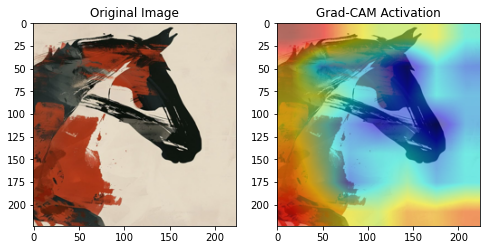

In [54]:
# 📌 Display results
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Grad-CAM Activation")

plt.show()

## Analyzing Artistic style

In [55]:
def analyze_artistic_style(heatmap, image_tensor):
    """
    Analyze artistic style based on Grad-CAM activations and suggest improvements.
    """
    insights = []
    
    # Check if heatmap has strong activations in certain areas
    mean_activation = np.mean(heatmap)
    
    if mean_activation > 0.6:
        insights.append("High activation in focal areas suggests strong emphasis on contrast.")
    else:
        insights.append("Lower activation in key regions. Consider emphasizing focal points.")

    # Check color balance using image tensor
    mean_colors = image_tensor.mean(dim=(1, 2)).tolist()
    
    if mean_colors[0] > mean_colors[1] and mean_colors[0] > mean_colors[2]:
        insights.append("Dominant warm tones detected. Consider balancing with cooler shades.")
    else:
        insights.append("Cool color palette detected. Try adding warm highlights for depth.")

    return insights


In [56]:
# 📌 Get analysis insights
insights = analyze_artistic_style(heatmap, image_tensor)


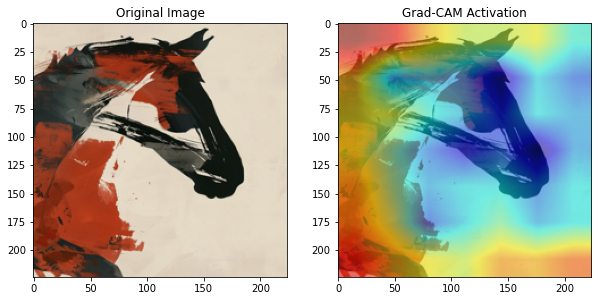


🎨 **Artistic Analysis & Suggestions:**
- High activation in focal areas suggests strong emphasis on contrast.
- Dominant warm tones detected. Consider balancing with cooler shades.


In [57]:
# 📌 Display insights along with images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Grad-CAM Activation")

plt.show()
# Print the analysis results
print("\n🎨 **Artistic Analysis & Suggestions:**")
for insight in insights:
    print(f"- {insight}")